## Intro to MLP

This notebook is provides the code that I use in my blog post. It is preferrable to read the post first, attempt to implement everything yourself and use this notebook as a solution key.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [3]:
np.random.seed(0) # For reproducibility

In [4]:
# Colors for visualization
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#4287f5', '#f55a42'])

### Dataset

We will be working with a synthetic dataset that consists of two co-centric circles, with each circle being a different class. The goal is to seperate the two classes. The below function creates points that lie on a circle.

In [5]:
def circle(center, radius, num_points, noise_std):
    h, k = center
    theta = np.random.uniform(0, 1, size=num_points) * np.pi * 2
    x = (h + np.cos(theta) * radius) + np.random.normal(0, noise_std, size=num_points)
    y = (k + np.sin(theta) * radius) + np.random.normal(0, noise_std, size=num_points)
    
    return np.column_stack((x, y))

In [6]:
def make_circles(center, r1, r2, num_points, noise_std):
    c1 = circle(center, r1, num_points // 2, noise_std)
    y1 = np.zeros(num_points // 2)
    
    c2 = circle(center, r2, num_points // 2, noise_std)
    y2 = np.ones(num_points // 2)
    
    X = np.vstack((c1, c2))
    y = np.append(y1, y2)
    
    p = np.random.permutation(len(y))
    
    return X[p], y[p].reshape(-1, 1)

#### Data generation parameters

In [15]:
center = (0, 0)
radius1 = 3
radius2 = 1
num_points = 200
noise_lvl = 0.05

In [16]:
X, y = make_circles(center, radius1, radius2, num_points, noise_lvl)

#### Visualize 

In [17]:
def plot(X, y, img_name=''):
    fig = plt.figure(figsize=(6, 6))
    plt.axes().set_aspect('equal', 'datalim')
    plt.box(False)
    plt.axis('off')
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolors='k', s=50, cmap=cm_bright)
    plt.show()
    if img_name:
        fig.savefig(f'{img_name}.png')

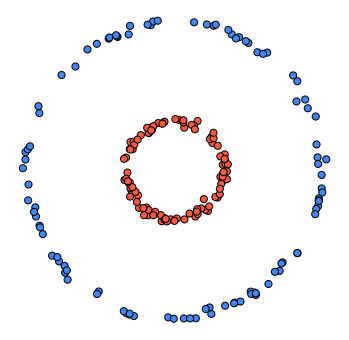

In [18]:
plot(X, y, 'circles')

### Transformation

We can see from the above visual that the data is not linearly separable. However, since we know the data generating process we can easily make it linearly separable by applying a transformation function to the data points. 

In general it's hard to know what transformation to apply since we usually have very limited knowledge on what the actual function is that generated the data. It would be great if we had a way to learn the transformation that makes the data linearly separable directly from the data itself. This is where Multilayer Perceptrons come in.

In [21]:
X_transformed = np.square(X)

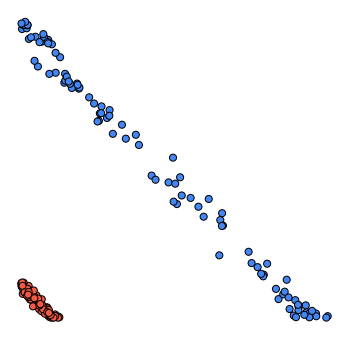

In [22]:
plot(X_transformed, y, 'circles_transformed.png')

## Implementation

### Initialize the parameters

We are defining a two-layer MLP with 3 hidden units. 

In [15]:
hidden_size = 3
W1 = np.random.uniform(0, 1, size=(X.shape[1], hidden_size))
b1 = np.random.uniform(0, 1, size=(1, hidden_size))

W2 = np.random.uniform(0, 1, size=(hidden_size, 1))
b2 = np.random.uniform(0, 1, size=(1, 1))

### Activation Function

In [16]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

### Loss Function

Binary cross entropy loss which corresponds to negative log likelihood

In [17]:
def loss(y_true, y_pred):
    return np.mean(-y_true*np.log(y_pred) - (1 - y_true)*np.log(1 - y_pred))

### Forward Pass

In [18]:
def forward(X, W1, b1, W2, b2):
    # We will need the output of the hidden layer in the backward pass
    h = sigmoid(np.dot(X, W1) + b1)
    scores = np.dot(h, W2) + b2
    y_pred = sigmoid(scores)
    return h, scores, y_pred

### Backward Pass

In [19]:
def backward(X, h, scores, y_pred):
    ds2 = y_pred - y
    dW2 = np.dot(h.T, ds2)
    db2 = np.sum(ds2, axis=0, keepdims=True)
    dh = W2 * ds2.T
    ds1 = dh.T * (h * (1 - h))
    dW1 = np.dot(X.T, ds1)
    db1 = np.sum(ds1, axis=0, keepdims=True)
    
    return dW1, db1, dW2, db2

### Training

In [20]:
lr = 0.01 # Learning rate (step size)
for i in range(1001): # Number of epochs
    hidden_layer, scores, y_pred = forward(X, W1, b1, W2, b2)
    dW1, db1, dW2, db2 = backward(X, hidden_layer, scores, y_pred)
    
    # Update the weights
    W2 -= lr*dW2
    b2 -= lr*db2
    W1 -= lr*dW1
    b1 -= lr*db1
    
    # Print progress
    if i % 100 == 0:
        print(f'Loss Value: {loss(y, y_pred)}  Epoch: {i}')      

Loss Value: 1.0444629916887918  Epoch: 0
Loss Value: 0.4114403226061387  Epoch: 100
Loss Value: 0.28499277902074643  Epoch: 200
Loss Value: 0.1359645075016534  Epoch: 300
Loss Value: 0.04358676655126231  Epoch: 400
Loss Value: 0.02688514725899614  Epoch: 500
Loss Value: 0.01956245659695224  Epoch: 600
Loss Value: 0.015376539924274577  Epoch: 700
Loss Value: 0.012657936773880892  Epoch: 800
Loss Value: 0.010749305316402004  Epoch: 900
Loss Value: 0.009335944100866465  Epoch: 1000


#### Accuracy

In [21]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

In [22]:
_, _, y_pred = forward(X, W1, b1, W2, b2)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [23]:
accuracy(y, y_pred)

1.0

### Visualizations

In [24]:
def plot_decision_boundary():
    fig = plt.figure(figsize=(6, 6))
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    _, _, Z = forward(np.c_[xx.ravel(), yy.ravel()], W1, b1, W2, b2)
    Z[Z >= 0.5] = 1
    Z[Z < 0.5] = 0
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolors='k', cmap=cm_bright)
    plt.show()

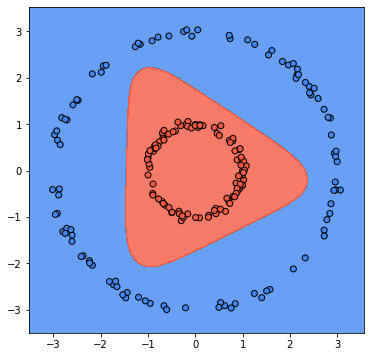

In [25]:
plot_decision_boundary()

In [26]:
def plot_hidden_layer(hidden_layer):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(hidden_layer[:, 0], hidden_layer[:, 1], hidden_layer[:, 2], c=y.flatten(), cmap=cm_bright)
    ax.view_init(20, 230)
    plt.tight_layout()
    fig.savefig('projection.png')
    plt.show()

In [27]:
hidden_layer, _, _ = forward(X, W1, b1, W2, b2)

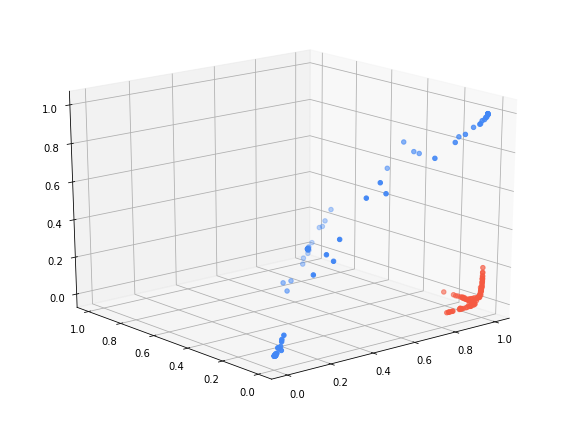

In [28]:
plot_hidden_layer(hidden_layer)

In [29]:
def line_from_weights(x, w1, w2, b):
    return - x * (w1/w2) - (b/w2)

In [30]:
def plot_first_weights(W1, b1):
    fig, ax = plt.subplots(figsize=(6, 6))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    x = np.linspace(x_min, x_max, 100)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolors='k', cmap=cm_bright)
    for i in range(hidden_size):
        x_out = line_from_weights(x, W1.T[i][0], W1.T[i][1], b1[0][i])
        ax.plot(x, x_out, '--k')
        ax.set_xlim((x_min, x_max))
        ax.set_ylim((y_min, y_max))
    ax.set_aspect('equal', 'datalim')
    plt.tight_layout()
    fig.savefig('hidden_classifiers.png')

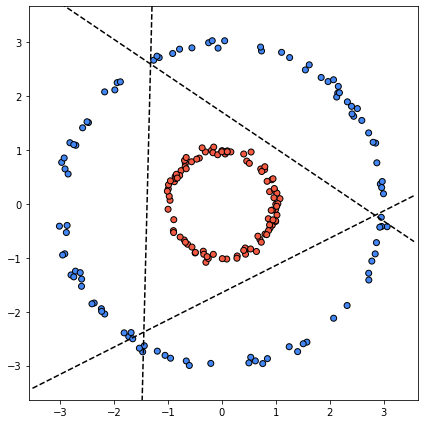

In [31]:
plot_first_weights(W1, b1)